In [13]:
!pip install category_encoders
!pip install texthero

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 238 kB 9.9 MB/s 
     |████████████████████████████████| 1.4 MB 7.6 MB/s 
     |████████████████████████████████| 10.4 MB 5.8 MB/s 
     |████████████████████████████████| 366 kB 3.4 MB/s 
     |████████████████████████████████| 24.2 MB 5.4 MB/s 
     |████████████████████████████████| 6.8 MB 11.1 MB/s 
     |████████████████████████████████| 82 kB 2.4 MB/s 
     |████████████████████████████████| 723 kB 15.3 MB/s 
     |████████████████████████████████| 293 kB 2.6 MB/s 
     |████████████████████████████████| 284 kB 3.4 MB/s 
     |████████████████████████████████| 1.1 MB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 9.9 MB/s 
     |████████████████████████████████| 117 kB 17.9 MB/s 
  Cr

In [1]:
import pandas as pd
import pathlib
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import texthero as hero
from texthero import preprocessing

from sklearn import metrics
from sklearn.model_selection import GroupKFold, KFold

import lightgbm as lgb

from sklearn.metrics import mean_squared_error, mean_squared_log_error


In [2]:
DATA_DIR = pathlib.Path('/home/knikaido/work/atma8/data/')
OUTPUT_DIR = './sub03/'
train_csv_path = DATA_DIR / 'train.csv'
test_csv_path = DATA_DIR / 'test.csv'

In [3]:
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

In [4]:
train_column = train_df.columns

In [5]:
X_column = []
for s in train_column:
    if not'Sales' in s:
        X_column.append(s)

In [6]:
train_df_drop = train_df[X_column]

In [7]:
# User_Scoreの変換
def make_user_score(df):
    d = df['User_Score'].copy()
    d[d == 'tbd'] = 'nan'
    df.loc[:,'User_Score'] = d
    
    return df

In [8]:
train_df_drop = make_user_score(train_df_drop)
test_df = make_user_score(test_df)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [9]:
# Ratingの変換

In [10]:
def encode_label(train, test):
    cate_col = ['Rating', 'Platform', 'Genre']
    oe = ce.OrdinalEncoder(cols=cate_col, drop_invariant=True, handle_missing='return_nan')
    train.loc[:,cate_col] = oe.fit_transform(train[cate_col])
    test.loc[:,cate_col] = oe.transform(test[cate_col])
    return train, test

In [11]:
train_df_drop, test_df = encode_label(train_df_drop, test_df)

/home/user/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1717: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [12]:
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace
                  ]

In [13]:
l_ = hero.pca(hero.tfidf(hero.clean(train_df_drop['Publisher'], pipeline=custom_pipeline)))
l_t = hero.pca(hero.tfidf(hero.clean(test_df['Publisher'], pipeline=custom_pipeline)))

In [14]:
l__ = []
for i in range(len(l_)):
    l__.append(l_.values[i])
l__ = np.array(l__)

l__t = []
for i in range(len(l_t)):
    l__t.append(l_t.values[i])
l__t = np.array(l__t)

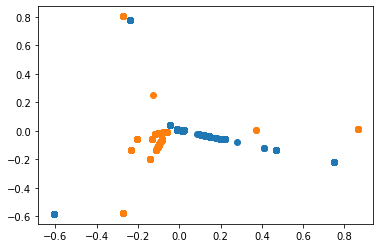

In [15]:
plt.scatter(l__[:,0], l__[:,1])
plt.scatter(l__t[:,0], l__t[:,1])

In [47]:
train_df_drop['0'] =  l__[:, 0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [48]:
train_df_drop

,Name,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,0
0,LEGO Batman: The Videogame,1.0,NaN,1.0,Warner Bros. Interactive Entertainment,74.0,17.0,7.9,22.0,Traveller's Tales,1.0,0.242291
1,LEGO Indiana Jones: The Original Adventures,1.0,NaN,1.0,LucasArts,78.0,22.0,6.6,28.0,Traveller's Tales,1.0,0.143287
2,LEGO Batman: The Videogame,2.0,NaN,1.0,Warner Bros. Interactive Entertainment,73.0,5.0,7.4,10.0,Traveller's Tales,1.0,0.242291
3,Combat,3.0,NaN,1.0,Atari,NaN,NaN,NaN,NaN,NaN,NaN,-0.043805
4,LEGO Harry Potter: Years 5-7,1.0,NaN,1.0,Warner Bros. Interactive Entertainment,76.0,8.0,7.8,13.0,Traveller's Tales,1.0,-0.005716
...,...,...,...,...,...,...,...,...,...,...,...,...
8354,Stellaris,9.0,2016.0,12.0,Paradox Interactive,78.0,57.0,8,569.0,Paradox Development Studio,NaN,-0.039644
8355,Total War Attila: Tyrants & Kings,9.0,2016.0,12.0,Koch Media,NaN,NaN,NaN,NaN,NaN,NaN,-0.025883
8356,Brothers Conflict: Precious Baby,14.0,2017.0,1.0,Idea Factory,NaN,NaN,NaN,NaN,NaN,NaN,-0.038582
8357,Phantasy Star Online 2 Episode 4: Deluxe Package,30.0,2017.0,8.0,Sega,NaN,NaN,NaN,NaN,NaN,NaN,-0.029639


In [12]:
drop_c = ['Name', 'Publisher', 'Developer']
train_df_drop.drop(drop_c, axis=1, inplace=True)
test_df.drop(drop_c, axis=1, inplace=True)
train_df_drop

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Platform,Year_of_Release,Genre,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,1.0,NaN,1.0,74.0,17.0,7.9,22.0,1.0
1,1.0,NaN,1.0,78.0,22.0,6.6,28.0,1.0
2,2.0,NaN,1.0,73.0,5.0,7.4,10.0,1.0
3,3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,1.0,NaN,1.0,76.0,8.0,7.8,13.0,1.0
...,...,...,...,...,...,...,...,...
8354,9.0,2016.0,12.0,78.0,57.0,8,569.0,NaN
8355,9.0,2016.0,12.0,NaN,NaN,NaN,NaN,NaN
8356,14.0,2017.0,1.0,NaN,NaN,NaN,NaN,NaN
8357,30.0,2017.0,8.0,NaN,NaN,NaN,NaN,NaN


In [13]:
train_df_drop = train_df_drop.astype('float64')
test_df = test_df.astype('float64')

In [14]:
X = train_df_drop
y = train_df['Global_Sales'].astype('float64')
groups = train_df['Publisher']

In [15]:


# kfoldの分割数
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=0)
# kf = GroupKFold(n_splits=k)

lgbm_params = {'objective': 'regression',
              "metric":"rmse",
              "learning_rate": 0.05,
               'colsample_bytree': 0.8}

rmsle_train_list = []
rmsle_eval_list = []

pred_test_np = np.zeros([k, len(test_df)])
oof_pred = np.zeros_like(y, dtype=np.float)

# kfoldで分割
for i, (train_index, test_index) in enumerate(kf.split(X, y)):

    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
    y_train = np.log1p(y_train)
    y_test = np.log1p(y_test)

    # データセットを生成する
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test)

    # 学習
    model = lgb.train(lgbm_params,
                        lgb_train,
                        valid_sets=[lgb_eval, lgb_train],
                        num_boost_round=10000,
                        early_stopping_rounds=1000,
                        verbose_eval=200)

    predict_train = model.predict(X_train, num_iteration=model.best_iteration)
    predict_eval = model.predict(X_test, num_iteration=model.best_iteration)
    oof_pred[test_index] = predict_eval
    
    rmsle_train = np.sqrt(mean_squared_error(y_train, predict_train))
    rmsle_eval = np.sqrt(mean_squared_error(y_test, predict_eval))
    print(f'RMSLE_train: {rmsle_train}, RMSLE_eval: {rmsle_eval}')
    rmsle_train_list.append(rmsle_train)
    rmsle_eval_list.append(rmsle_eval)
    
    pred_test_np[i] = model.predict(test_df, num_iteration=model.best_iteration)
    
print(f'RMSLE_train_mean: {np.mean(rmsle_train_list)}, RMSLE_eval_mean: {np.mean(rmsle_eval_list)}')

    # predict_probaが0.5以上なら1とする
#     predict = [0 if i < 0.5 else 1 for i in predict_proba]

#     auc, precision, recall = get_evaluate(y_test, predict)

#     print('AUC:{}, precision:{}, recall:{}'.format(auc, precision, recall))

#     auc_list.append(auc)
#     precision_list.append(precision)
#     recall_list.append(recall)

# # kfoldの平均値を取得
# print('Kfold平均 AUC:{}, precision:{}, recall:{}'.format(np.mean(auc_list), 
#                                                          np.mean(precision_list), 
#                                                          np.mean(recall_list)))

Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 0.910158	valid_0's rmse: 0.995739
[400]	training's rmse: 0.856605	valid_0's rmse: 0.998272
[600]	training's rmse: 0.824075	valid_0's rmse: 1.00187
[800]	training's rmse: 0.800106	valid_0's rmse: 1.00621
[1000]	training's rmse: 0.782397	valid_0's rmse: 1.00947
[1200]	training's rmse: 0.767911	valid_0's rmse: 1.01384
Early stopping, best iteration is:
[205]	training's rmse: 0.908064	valid_0's rmse: 0.995685
RMSLE_train: 0.9080635028676889, RMSLE_eval: 0.9956848392870129
Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 0.908927	valid_0's rmse: 1.01649
[400]	training's rmse: 0.854531	valid_0's rmse: 1.01849
[600]	training's rmse: 0.822302	valid_0's rmse: 1.02076
[800]	training's rmse: 0.798488	valid_0's rmse: 1.02318
[1000]	training's rmse: 0.780563	valid_0's rmse: 1.02916
[1200]	training's rmse: 0.767043	valid_0's rmse: 1.03227
Early stopping, best iteration is:
[224]

In [16]:
print(np.sqrt(mean_squared_error(np.log1p(y), oof_pred)))

1.0142231553851953


In [17]:
oof_df = pd.DataFrame(oof_pred, columns=['Global_Sales'])
oof_df.to_csv(OUTPUT_DIR + "oof03.csv", index = False)

In [18]:
pred_test_mean = np.mean(pred_test_np, axis=0)
pred_test_exp = np.expm1(pred_test_mean)

In [19]:
sub = pd.read_csv(DATA_DIR / 'atmaCup8_sample-submission.csv')
sub['Global_Sales'] = pred_test_exp
sub.to_csv(OUTPUT_DIR + "sub03.csv", index = False)

In [20]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    model = models
#     for i, model in enumerate(models):
    _df = pd.DataFrame()
    _df['feature_importance'] = model.feature_importance(importance_type='gain')
    _df['column'] = feat_train_df.columns
    _df['fold'] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

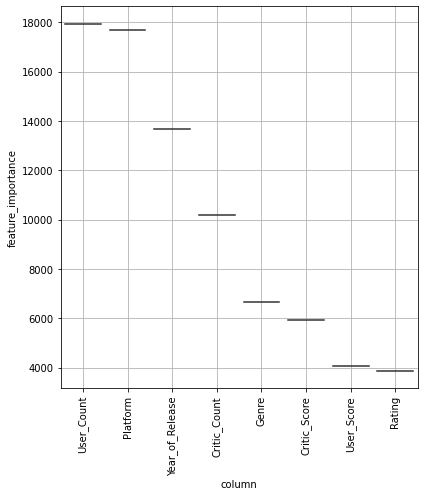

In [21]:
fig, ax = visualize_importance(model, X)


In [22]:
importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=train_df_drop.columns, columns=['importance'])
importance.sort_values(['importance'])

,importance
Rating,3867.059397
User_Score,4067.126756
Critic_Score,5925.953524
Genre,6671.714351
Critic_Count,10195.959010
Year_of_Release,13656.090352
Platform,17673.861843
User_Count,17940.815982
